# Week 5 - Logistic Regression and Classification Error Metrics

## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

Alternatively the same data set can be found at https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones/downloads/human-activity-recognition-with-smartphones.zip
The train file can be renamed as Human_Activity_Recognition_Using_Smartphones_Data.csv 

For each record in the dataset it is provided: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration. 
- Triaxial Angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 

More information about the features is available on the website above.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Question 1

Import the data and do the following:

* Examine the data types--there are many columns, so it might be wise to use value counts
* Determine if the floating point values need to be scaled
* Determine the breakdown of each activity
* Encode the activity label as an integer

In [2]:
import pandas as pd
import numpy as np

filepath= 'https://raw.githubusercontent.com/yoel2000/Computational-learning/main/Data/Human_Activity_Recognition_Using_Smartphones_Data.csv'
data = pd.read_csv(filepath, sep=',')

The data columns are all floats except for the activity label.

In [2]:
data.dtypes.value_counts()

float64    561
object       1
dtype: int64

In [3]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

In [4]:
data.dtypes

tBodyAcc-mean()-X                       float64
tBodyAcc-mean()-Y                       float64
tBodyAcc-mean()-Z                       float64
tBodyAcc-std()-X                        float64
tBodyAcc-std()-Y                        float64
                                         ...   
angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
Length: 562, dtype: object

The data are all scaled from -1 (minimum) to 1.0 (maximum).

In [5]:
data.iloc[:, :-1].min().value_counts()

-1.0    561
dtype: int64

In [10]:
data.iloc[:, :-1].max().value_counts()

1.0    561
dtype: int64

Examine the breakdown of activities--they are relatively balanced.

*When we used "[:, :-1]", we took everything except the last column.*

In [8]:
data.Activity.value_counts()

LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: Activity, dtype: int64

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.  
Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.

In [3]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)

9303    3
9201    2
7365    2
6418    4
8918    1
Name: Activity, dtype: int64

## Question 2

* Calculate the correlations between the dependent variables.
* Create a histogram of the correlation values
* Identify those that are most correlated (either positively or negatively).

In [4]:
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()
# print(corr_values)

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values) # Return the indices for the lower-triangle of arr.


# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values.stack().to_frame().reset_index().rename(columns={'level_0':'feature1','level_1':'feature2',0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

print(corr_values)

                                    feature1  ... abs_correlation
0                          tBodyAcc-mean()-X  ...        0.128037
1                          tBodyAcc-mean()-X  ...        0.230302
2                          tBodyAcc-mean()-X  ...        0.004590
3                          tBodyAcc-mean()-X  ...        0.016785
4                          tBodyAcc-mean()-X  ...        0.036071
...                                      ...  ...             ...
157075  angle(tBodyGyroJerkMean,gravityMean)  ...        0.004582
157076  angle(tBodyGyroJerkMean,gravityMean)  ...        0.012549
157077                  angle(X,gravityMean)  ...        0.748249
157078                  angle(X,gravityMean)  ...        0.635231
157079                  angle(Y,gravityMean)  ...        0.545614

[157080 rows x 4 columns]


A histogram of the absolute value correlations.

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

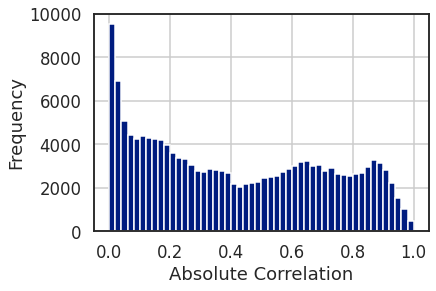

In [18]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

ax = corr_values.abs_correlation.hist(bins=50)

ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [5]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
101139,tBodyAccJerkMag-mean(),tBodyAccJerkMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
94257,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


## Question 3

* Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
* Regardless of methods used to split the data, compare the ratio of classes in both the train and test splits.


In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1,test_size=0.3, random_state=42) # n_splits: number of splitting iterations in the cross-validator

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']

In [22]:
y_train.value_counts(normalize=True)

0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: Activity, dtype: float64

In [23]:
y_test.value_counts(normalize=True)

0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: Activity, dtype: float64

## Question 4

* Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.
* Using cross validation to determine the hyperparameters, fit models using L1, and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.

In [30]:
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr = LogisticRegression().fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [29]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

In [33]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations
lr_newton = LogisticRegression(solver="newton-cg").fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)


In [36]:
lr_sag = LogisticRegression(solver="sag").fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [37]:
lr_saga = LogisticRegression(solver="saga").fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [34]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2').fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


## Question 5

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [38]:
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2', 'newton', 'sag', 'saga']
coeff_models = [lr, lr_l1, lr_l2, lr_newton, lr_sag, lr_saga]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_ # stimated coefficients for the linear regression problem
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)

lr                      ...      saga                    
            0         1         2  ...         3         4         5
12  -0.050139  0.130218  0.003747  ... -0.035409  0.281895 -0.343376
377 -0.031662  0.247481 -0.276287  ...  0.319042 -0.231245 -0.053472
520 -0.051674 -0.047850 -0.138665  ...  0.037566  0.173248  0.041680
70  -0.150468  0.021928  0.136706  ... -0.500332 -0.098503  0.582705
411 -0.004239 -0.004403 -0.021099  ... -0.082095  0.230618 -0.203104
17   0.000106 -0.027100  0.008472  ...  0.010160 -0.082423 -0.001522
395 -0.016376 -0.022571 -0.094917  ... -0.157353  0.265554 -0.037982
450 -0.019919  0.012462 -0.016911  ...  0.740965 -0.116813 -0.666346
373  0.033033 -0.369987  0.404025  ...  0.136311 -0.011486 -0.222767
80   0.025305  0.130954 -0.166150  ...  0.032097  0.064522 -0.098233

[10 rows x 36 columns]

Prepare six separate plots for each of the multi-class coefficients.

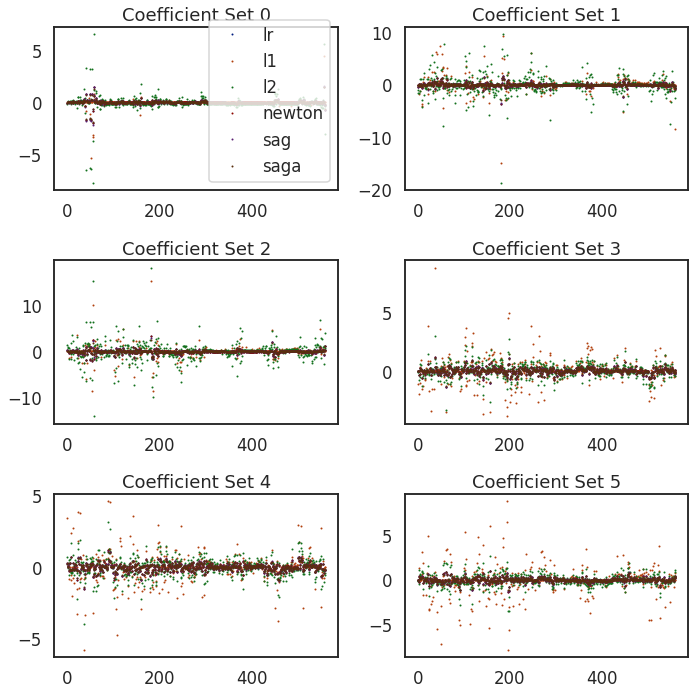

In [39]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=1.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()


## Question 6

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [42]:
# Predict the class and the probability for each

y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2', 'newton', 'sag', 'saga']
coeff_models = [lr, lr_l1, lr_l2, lr_newton, lr_sag, lr_saga]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()


,lr,l1,l2,newton,sag,saga
0,3,3,3,3,3,3
1,5,5,5,5,5,5
2,3,3,3,3,3,3
3,1,1,1,1,1,1
4,0,0,0,0,0,0


In [43]:
y_prob.head()

,lr,l1,l2,newton,sag,saga
0,0.999987,0.998999,1.000000,0.999987,0.999985,0.999983
1,0.998361,0.999145,1.000000,0.998361,0.998398,0.997906
2,0.996546,0.995110,0.999998,0.996546,0.996587,0.996071
3,0.990812,0.999184,1.000000,0.990812,0.989892,0.987170
4,0.998089,0.999920,1.000000,0.998089,0.998131,0.997810


## Question 7

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [44]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)


In [45]:
#Run the metrics
metrics

,lr,l1,l2,newton,sag,saga
precision,0.983811,0.984153,0.986090,0.983811,0.984133,0.982518
recall,0.983819,0.984142,0.986084,0.983819,0.984142,0.982524
fscore,0.983811,0.984140,0.986085,0.983811,0.984136,0.982519
accuracy,0.983819,0.984142,0.986084,0.983819,0.984142,0.982524
auc,0.990184,0.990342,0.991545,0.990184,0.990393,0.989421


## Question 8

Display or plot the confusion matrix for each model.

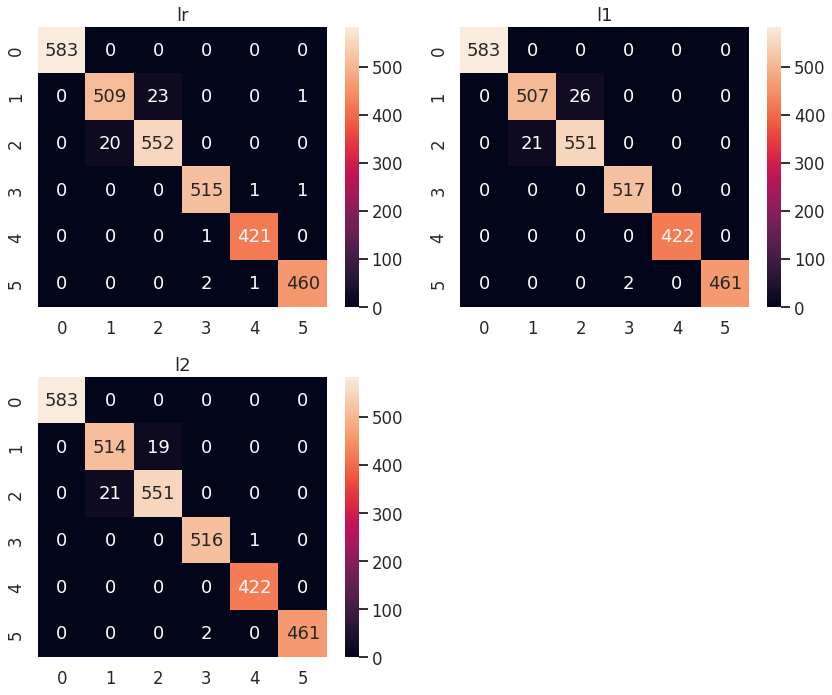

In [46]:

fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()


## Question 9
 Identify highly correlated columns and drop those columns before building models

In [7]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold

#threshold with .7

sel = VarianceThreshold(threshold=(.7 * (1 - .7)))


data2 = pd.concat([X_train,X_test])
data_new = pd.DataFrame(sel.fit_transform(data2))

data_y = pd.concat([y_train,y_test])

from sklearn.model_selection import train_test_split

X_new,X_test_new = train_test_split(data_new)
Y_new,Y_test_new = train_test_split(data_y)

 Repeat Model building with new training data after removing higly correlated columns

In [9]:
from sklearn.linear_model import LogisticRegression
new_lr = LogisticRegression().fit(X_new, Y_new)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [10]:
from sklearn.linear_model import LogisticRegressionCV
new_lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_new, Y_new)

In [11]:
new_lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2').fit(X_new, Y_new)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [13]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations
# The default is 'lbfgs'. So, I didn't create a test for this solver because we calculate it with "new_lr"
new_lr_newton = LogisticRegression(solver="newton-cg").fit(X_new, Y_new)

new_lr_sag = LogisticRegression(solver="sag").fit(X_new, Y_new)

new_lr_saga = LogisticRegression(solver="saga").fit(X_new, Y_new)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


## Question 10

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [14]:
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2', 'newton', 'sag', 'saga']
coeff_models = [new_lr, new_lr_l1, new_lr_l2, new_lr_newton, new_lr_sag, new_lr_saga]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_ # stimated coefficients for the linear regression problem
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)

lr                      ...      saga                    
           0         1         2  ...         3         4         5
47  0.014326 -0.032938  0.011557  ...  0.032633 -0.010871 -0.019181
3   0.072496  0.102868 -0.154758  ... -0.274596  0.379411 -0.213522
36  0.038781  0.194473  0.161736  ...  0.054927 -0.048412 -0.278045
33 -0.264810  1.000158 -0.095905  ... -0.095922 -0.479067 -0.015052
29  0.061836 -0.178680  0.130582  ...  0.139285  0.167097 -0.156149
41  0.162075  0.084360 -0.220266  ...  0.084891  0.244382 -0.335256
23  0.067588  0.132297  0.312838  ... -0.069851 -0.328741 -0.038511
27 -0.130493  0.106775  0.094997  ...  0.095461 -0.016718 -0.166605
0   0.229982 -0.094482  0.044814  ... -0.313528  0.217301 -0.070856
11  0.027595 -0.009162 -0.036530  ... -0.055504  0.028041  0.044671

[10 rows x 36 columns]

Prepare six separate plots for each of the multi-class coefficients.

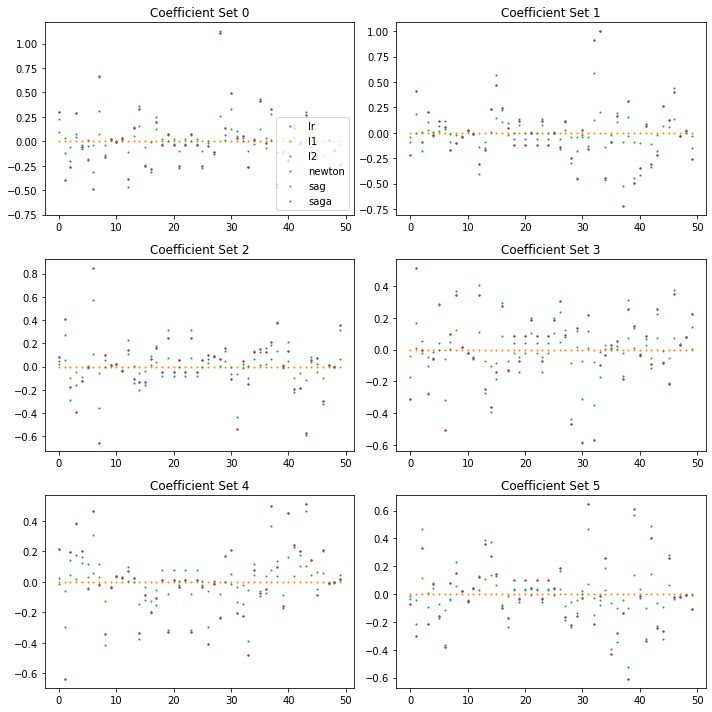

In [17]:
# try the plots

fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=1.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()

## Question 11

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [19]:
# Predict the class and the probability for each

y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2', 'newton', 'sag', 'saga']
coeff_models = [new_lr, new_lr_l1, new_lr_l2, new_lr_newton, new_lr_sag, new_lr_saga]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test_new), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test_new).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()


,lr,l1,l2,newton,sag,saga
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,2,0,0,0
4,0,0,0,0,0,0


In [20]:
y_prob.head()

,lr,l1,l2,newton,sag,saga
0,0.196136,0.166667,0.193135,0.197444,0.197444,0.197442
1,0.215623,0.166667,0.212304,0.215660,0.215662,0.215664
2,0.196483,0.166667,0.187974,0.191999,0.191997,0.191993
3,0.188105,0.166667,0.193703,0.191346,0.191343,0.191334
4,0.236671,0.166667,0.227707,0.234211,0.234212,0.234214


## Question 12

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [23]:
# Calculate the error metrics as listed above
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(Y_test_new, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(Y_test_new, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(Y_test_new, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(Y_test_new, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
#Run the metrics
metrics

,lr,l1,l2,newton,sag,saga
precision,0.182088,0.035038,0.142032,0.169923,0.169923,0.169923
recall,0.179029,0.187184,0.186796,0.179029,0.179029,0.179029
fscore,0.149766,0.059027,0.139922,0.147844,0.147844,0.147844
accuracy,0.179029,0.187184,0.186796,0.179029,0.179029,0.179029
auc,0.499016,0.500000,0.502112,0.499046,0.499046,0.499046


## Question 13

Display or plot the confusion matrix for each model.

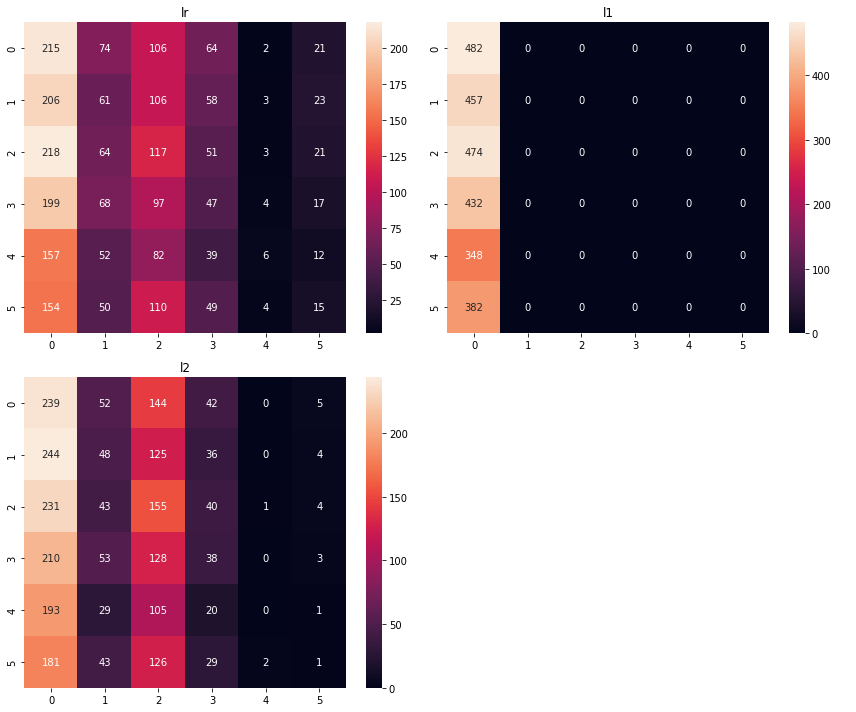

In [25]:
#plot the confusion matrix
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()

In [ ]:
# Perform a comparison of the outputs between Question 7 and 12 and give your observation

In [ ]:
# Perform a comparison of the outputs between Question 8 and 13 and give your observation